In [44]:
import pandas as pd
import numpy as np
import timeit

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (20.0, 10.0)
from matplotlib import colors

import scipy.stats
from scipy.stats import mannwhitneyu
import math
from matplotlib.lines import Line2D

%matplotlib inline

In [2]:
import plot
import calculate

In [3]:
#this defines the criterion which we use to filter authors
CAREER_LENGTH = 10 
END_YEAR = 2018
MAX_CAREER_LENGTH_COHORT = 15    # this defines how long we follow each cohort


## Load data

In [4]:
# Publication data
authorPublicationData = pd.read_csv('derived-data/author-publications-atleast-'+str(CAREER_LENGTH)+'-year.csv')
author_year_numPub = authorPublicationData.groupby(['author', 'year'])['pub_id'].count()

print("authorPublicationData no duplicates: ", authorPublicationData.shape[0])

#print(authorPublicationData.head())


authorPublicationData no duplicates:  5898126


In [5]:
credible_authors = pd.read_csv('derived-data/authors-scientific-atleast-'+ str(CAREER_LENGTH) + '-year-extended.csv', encoding='utf-8')

In [6]:
credible_authors = credible_authors.set_index('start_year')

print("credible_authors: ", credible_authors.shape[0])
print(credible_authors.head())

#print(credible_authors[credible_authors['author'] == 'donatella sciuto'])
credible_authors.rename(columns={'num_pub':'total_num_pub'}, inplace=True)



credible_authors:  255696
                      author  end_year  num_pub  career_length  max_absence  \
start_year                                                                    
2001        'maseka lesaoana      2015        2             15           14   
1992         a aart blokhuis      2005        2             14           13   
1979              a min tjoa      2017      191             39            7   
1992        a-imam al-sammak      2006        3             15           13   
1998              a-xing zhu      2017       22             20            5   

            avg_absence  dropped_after_10 gender  early_career_qual  \
start_year                                                            
2001          14.000000              True   none               23.0   
1992          13.000000              True   none                0.0   
1979           1.071429             False   none                0.0   
1992           7.000000              True      m                0

## Early career

In [ ]:
from matplotlib.lines import Line2D

zscore = True
numcols = 5
start_range = 1980
end_range = 2000
cells = end_range - start_range
numrows = int(cells/numcols)

var = "prod" # can also be qual

results = pd.DataFrame(columns=["year", "num_obs", "group", "slope", "intercept", "r_value", "p_value", "std_err"])
fig, ax = plt.subplots(nrows=numrows, ncols=numcols, sharex=False, sharey=False, figsize=(20,15))


custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='black', lw=4)]
for year in range(start_range, end_range):
    data = credible_authors.loc[year]
    x = data['early_career_prod']
    
    
    if(zscore):
        y = (data['succ_after_15y']-np.mean(data['succ_after_15y']))/np.std(data['succ_after_15y'])
    else:
        y = data['succ_after_15y']/np.sum(data['succ_after_15y'])
   
    x_f = data[data.gender == 'f']['early_career_prod']
    if(zscore):
        y_f = (data[data.gender == 'f']['succ_after_15y']-np.mean(data['succ_after_15y']))/np.std(data['succ_after_15y'])
    else:
        y_f = data[data.gender == 'f']['succ_after_15y']/np.sum(data['succ_after_15y'])
    
    x_m = data[data.gender == 'm']['early_career_prod']
    if(zscore):
        y_m = (data[data.gender == 'm']['succ_after_15y']-np.mean(data['succ_after_15y']))/np.std(data['succ_after_15y'])
    else:
        y_m = data[data.gender == 'm']['succ_after_15y']/np.sum(data['succ_after_15y'])
    

    axes = ax[(year-start_range)//numcols,year%start_range%numcols]
    axes.scatter(x, y, color="black")
    axes.scatter(x_m, y_m, color="blue")
    axes.scatter(x_f, y_f, color="red")
    fit = np.polyfit(x, y, deg=1)
    fit_f = np.polyfit(x_f, y_f, deg=1)
    fit_m = np.polyfit(x_m, y_m, deg=1)
    #axes.plot(x, fit[0] * x + fit[1], color='black')
    axes.plot(x_f, fit_f[0] * x_f + fit_f[1], color='red')
    axes.plot(x_m, fit_m[0] * x_m + fit_m[1], color='blue')
    axes.set_title("Cohort: " + str(year))
    # plt.xlim(0, 50)
    # plt.ylim(0,200)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    results = results.append({"year":year, "num_obs":len(x), "group":"all", "slope":slope, "intercept":intercept, 
                              "r_value":r_value, "p_value":p_value, "std_err":std_err}, ignore_index=True)
    
    m_slope, m_intercept, m_r_value, m_p_value, m_std_err = scipy.stats.linregress(x_m, y_m)
    results = results.append({"year":year, "num_obs":len(x_m), "group":"men", "slope":m_slope, "intercept":m_intercept, 
                              "r_value":m_r_value, "p_value":m_p_value, "std_err":m_std_err}, ignore_index=True)
    f_slope, f_intercept, f_r_value, f_p_value, f_std_err = scipy.stats.linregress(x_f, y_f)
    results = results.append({"year":year, "num_obs":len(x_f), "group":"women", "slope":f_slope, "intercept":f_intercept, 
                              "r_value":f_r_value, "p_value":f_p_value, "std_err":f_std_err}, ignore_index=True)
    
    #print(slope, intercept)
    #axes.add_artist(axes.legend("R squared: " + str(r_value), loc=2))
    axes.annotate("R squared: " + str(np.round(r_value, decimals=3))+"\nSlope: "+str(np.round(slope, decimals=3)), xy=(0.01,0.8), xycoords='axes fraction', fontsize=14)
    #axes.legend(custom_lines, ['Female', 'Male', 'All'], loc=1)
fig.text(0.5, 0.1, 'Early Career Productivity', ha='center', va='center')
fig.text(0.06, 0.5, 'Final Success', ha='center', va='center', rotation='vertical')
plt.show()
if(zscore):
    fig.savefig("fig/earlycareer_"+str(var)+"_final_success_zscore.png", edgecolor='none', bbox_inches='tight')
else:
    fig.savefig("fig/earlycareer_"+str(var)+"_final_success.png", edgecolor='none', bbox_inches='tight')

print(results.head())
if(zscore):
    results.to_csv("fig/earlycareer_"+str(var)+"_final_success_zscore.csv")
else:
    results.to_csv("fig/earlycareer_"+str(var)+"_final_success.csv")

In [ ]:
results[results.year==1985]

In [ ]:
for group in ['all', 'men', 'women']:
    temp = results[results.group == group]
    plt.plot(temp['year'], temp['r_value'], label=group)
plt.xlabel("Year")
plt.ylabel("R squared (productivity and success)")
plt.title("R squared over cohorts for " + group)
plt.ylim((0,0.6))
plt.legend()
plt.show()

In [ ]:
for group in ['all', 'men', 'women']:
    temp = results[results.group == group]
    plt.plot(temp['year'], temp['slope'], label=group)
plt.xlabel("Year")
plt.ylabel("Slope (productivity and success)")
plt.title("Slope over cohorts for " + group)
plt.legend()
plt.show()

In [ ]:
results.head()

## Publications analysis

In [7]:
credible_authors.reset_index(inplace=True)

In [8]:
# #print(credible_authors.head(n=1))
# credible_authors[credible_authors['author'] == 'donatella sciuto'].head(5)

# #print("-----------------------------------------")
# #print(authorPublicationData.head(n=1))

# authorPublicationData[authorPublicationData['author'] == 'donatella sciuto'].head(5)


temp = authorPublicationData.groupby(['year','author']).count().reset_index()
temp = temp.rename(columns={'pub_id':'num_pub'}, inplace=False)

# #print(temp[temp['author'] == 'donatella sciuto'].head(3))


authorPublicationData = temp.merge(credible_authors, how="inner", on=["author"])

# print(authorPublicationData[authorPublicationData['author'] == 'donatella sciuto'].head(3))

# authorPublicationData.shape



groupByYearData = calculate.groupDataAndCalculateCumulativeValues(authorPublicationData, 1, 'num_pub')

# #print(np.unique(groupByYearData['gender']))
authorPublicationData['gender'] = authorPublicationData['gender'].fillna('none')


years = groupByYearData['year'].unique()
years = sorted(years)

cohort_start_years = [y for y in years if y < (END_YEAR - MAX_CAREER_LENGTH_COHORT)]



In [9]:
# # here is a bug; total_num_pub of this author is 349; num_pub and cum_num_pub should only contain publications in "year"
#print(groupByYearData.head(n=1))
# print(np.unique(groupByYearData["year"]))

print(groupByYearData[groupByYearData['author'] == '\'maseka lesaoana'].head(10))
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
print(groupByYearData[groupByYearData['author'] == '(max) zong-ming cheng'].head(10))

#print(groupByYearData.sort_values(by=['author', 'year']).head())

         year            author  num_pub  start_year  end_year  total_num_pub  \
448881   2001  'maseka lesaoana        1        2001      2015              2   
2029249  2015  'maseka lesaoana        1        2001      2015              2   

         career_length  max_absence  avg_absence  dropped_after_10 gender  \
448881              15           14         14.0              True   none   
2029249             15           14         14.0              True   none   

         early_career_qual  early_career_recognition  succ_after_15y  \
448881                23.0                       5.0            23.0   
2029249               23.0                       5.0            23.0   

         early_career_prod  cum_num_pub  
448881                   1            1  
2029249                  1            2  
Empty DataFrame
Columns: [year, author, num_pub, start_year, end_year, total_num_pub, career_length, max_absence, avg_absence, dropped_after_10, gender, early_career_qual, early_car

In [16]:
from importlib import reload
reload(plot)
reload(calculate)

<module 'calculate' from '/home/danielkostic/cumulative-advantage/calculate.py'>

In [11]:
cohort_careerage_df = plot.get_cohort_careerage_df(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_pub", credible_authors)

#------------------------------------------
# some plausibility checks
# print(cohort_careerage_df.head(n=1))
# subset1 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 1) & (cohort_careerage_df.gender == "all")]
# vals1 = subset1["values"]

# subset10 = cohort_careerage_df[(cohort_careerage_df.cohort_start_year == 1991) & (cohort_careerage_df.career_age == 10) & (cohort_careerage_df.gender == "all")]
# vals10 = subset10["values"]

# from collections import Counter

# print(type(vals1))
# print(Counter(vals1.values[0]))
# print(len(vals1.values[0]))


# print(type(vals10))
# print(Counter(vals10.values[0]))
# print(len(vals10.values[0]))


In [12]:
groupByYearData, cohort_start_years, max_career_age_cohort, criterion, criterion_display, authorStartEndCareerData = groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_pub", "Publications", credible_authors

In [13]:
cohort_careerage_df = plot.get_cohort_careerage_df(groupByYearData, cohort_start_years, max_career_age_cohort, criterion, authorStartEndCareerData)


In [17]:
cohort_effect_size = plot.get_cohort_effect_size(cohort_careerage_df)

In [18]:
cohort_effect_size.head()

,cohort_start_year,career_age,values,effect,statistic,pvalue
0,1970,1,"([1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0,...",0.022447,1931.0,0.525210
1,1970,2,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.001940,1857.0,0.967378
2,1970,3,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.001109,1854.0,0.984109
3,1970,4,"([0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 0.0,...",0.075101,2121.0,0.140435
4,1970,5,"([0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0,...",0.026604,1946.0,0.625339


In [ ]:
# < 0,05 - significant difference

In [33]:
significant_effect = cohort_effect_size[cohort_effect_size.pvalue <= 0.05]

In [34]:
significant_effect.effect.mean()

0.040513442771317784

In [35]:
significant_effect.career_age.value_counts()

6     7
4     5
3     5
7     4
15    3
14    3
12    3
10    3
8     3
1     3
11    2
9     2
5     2
2     2
Name: career_age, dtype: int64

In [36]:
significant_effect = significant_effect.cohort_start_year.value_counts().to_frame()

In [41]:
significant_years = list(significant_effect[significant_effect.cohort_start_year > 5].index)

In [ ]:
cohort_effect_size

Typeerror occured
Typeerror occured
Typeerror occured
Typeerror occured
Typeerror occured
Typeerror occured
Typeerror occured
Typeerror occured
Typeerror occured
Typeerror occured
Typeerror occured
Typeerror occured
Typeerror occured


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


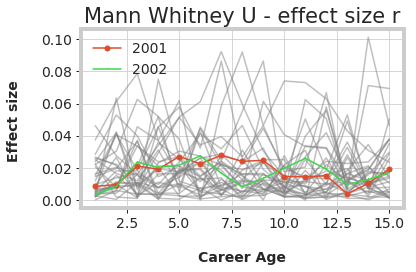

In [50]:
def plot_cohort_effect_size(cohort_effect_size):
    data = cohort_effect_size
    plt = plot.init_plotting()

    cohort_start_years = data.cohort_start_year.unique()

    fig2 = plt.figure()
    fig2.patch.set_facecolor('white')
    ax2 = fig2.add_subplot(1,1,1) #, axisbg="white"


    highlighted_cohorts = []  
    colors = ('#DE4C2C', '#3BD64C', '#3B9ED6', '#B73BD6', '#F39C12', '#FFC0CB', '#27AE60', '#48C9B0', '#071019') #'#AAB7B8',
    markers = []
    for m in Line2D.markers:
        try:
            if len(m) == 1 and m != ' ':
                markers.append(m)
        except TypeError:
            print("Typeerror occured")
            pass

    ax2.set_xlabel('Career Age', labelpad=20, fontweight='bold') 
    ax2.set_ylabel('Effect size ', labelpad=20, fontweight='bold')
    plt.title("Mann Whitney U - effect size r")

    p = 0
    for year in cohort_start_years: 
        cohort = data[data.cohort_start_year == year]

        if(year in significant_years):
            ax2.errorbar(cohort.career_age, cohort.effect, label=year, color=colors[p],
                         marker=markers[p], markersize=10)
            highlighted_cohorts.append(year)
            p = p+1 
        else:
            ax2.errorbar(cohort.career_age, cohort.effect, label=None, color='grey', alpha=0.5)

    plt.tight_layout()
    plt.legend()
    plt.show()

In [ ]:
cohort_careerage_df.loc[[1933, 1934]]

In [ ]:
a = cohort_careerage_df['values'][1933]
b = cohort_careerage_df['values'][1934]

In [ ]:
mannwhitneyu(a, b, alternative='two-sided')

In [ ]:
effect, statistic, pvalue = calculate.mann_whitney_effect_size(a,b, effect_formula='r')

In [ ]:
statistic

In [ ]:
mwu = mannwhitneyu([1,2,3,4,5], [2,3,4,5,6,7], alternative='two-sided')

In [ ]:
mwu.statistic

In [ ]:
mwu

In [ ]:
a = [2,4,3,1,2,3,3,2,3,1]

In [ ]:
b = [3,5,4,2,4,3,5,5,3,2]

In [ ]:
m = mannwhitneyu(a, b, alternative='two-sided')

In [ ]:
m

In [ ]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "num_pub", "Publications", credible_authors)  

In [ ]:
plot.run_cohort_analysis(groupByYearData, cohort_start_years, MAX_CAREER_LENGTH_COHORT, "cum_num_pub", "Cumulative Publications", credible_authors)  